# Prédiction sur les série temporelle

**Tâche : Importer les bibliothèques de base que vous pensez utiliser**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Données

Informations sur cet ensemble de données : https://fred.stlouisfed.org/series/IPN31152N


Unités :  Indice 2012=100, pas d'ajustement de saisonnalité

Fréquence :  Mensuelle

L'indice de production industrielle (IP) mesure la production réelle de tous les établissements concernés situés aux États-Unis, quel que soit leur propriétaire, mais pas ceux situés sur le territoire américain.

SCIAN = 31152

Code source : IP.N31152.N

Citation suggérée :
Conseil des gouverneurs de la Réserve fédérale (États-Unis), Production industrielle : Biens non durables : Glaces et desserts glacés [IPN31152N], extrait de FRED, Federal Reserve Bank of St. Louis ; https://fred.stlouisfed.org/series/IPN31152N, 16 novembre 2019.

# Tâches du projet

**Tâche : Lire le dataset de votre choix contenant des données sur des série temporelle. Trouvez comment définir la date en tant qu'index de colonne datetime**

In [2]:
consumer_df = pd.read_csv("Consumer_Price_Index_for_All_Urban_Consumers.csv",index_col='DATE',parse_dates=True)

In [3]:
consumer_df.head()

,CPIAUCSL
DATE,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


**Tâche : Changer le nom de la colonne avec le nom Consommation**

In [4]:
consumer_df.columns = ["Consommation"]

In [5]:
consumer_df.head()

,Consommation
DATE,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


**Tâche : Tracer les séries temporelles**

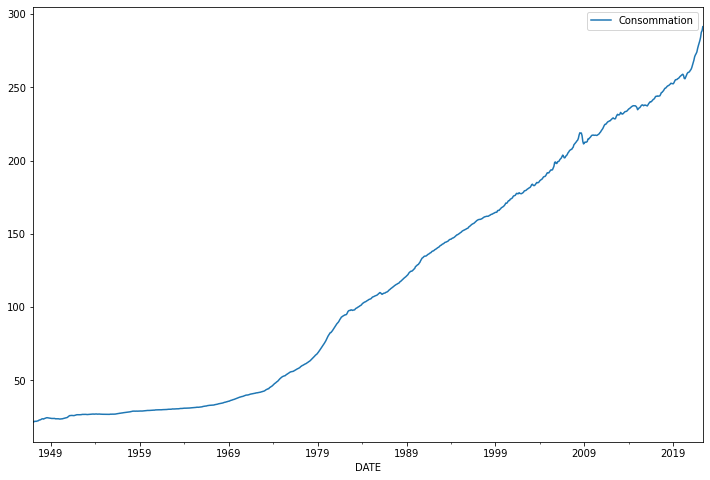

In [6]:
consumer_df.plot(figsize=(12,8))

## Répartition Entraînement / Test

**Tâche : Déterminer la longueur (taille) du dataset**

In [7]:
len(consumer_df)

905

**Tâche : Diviser les données en un set d'entraînement et un set de test où l'ensemble de test correspond aux données des 24 derniers mois.**

In [8]:
test_size = 24 # periode de 24 mois soit 2 ans
test_ind = len(consumer_df) - test_size

In [9]:
train = consumer_df.iloc[:test_ind]
test = consumer_df.iloc[test_ind:]

In [10]:
len(train)

881

In [11]:
len(test)

24

## Mise à l'échelle des données

**Tâche : Utiliser MinMaxScaler pour mettre à l'échelle les ensembles de données d'entraînement et de test dans leurs versions mises à l'échelle.**

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Générateur de séries temporelles

**Tâche : Créer un objet TimeSeriesGenerator qui se base sur les données scaled_train. La longueur du batch dépend de vous, mais elle doit être au minimum de 18 pour saisir une saisonnalité d'une année complète.**

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 18 # batch, pour 18 mois
n_features=1 # feature : consommation

In [18]:
generator = TimeseriesGenerator(
    scaled_train, 
    scaled_train, 
    length=length, 
    batch_size=1
)

## Création du modèle

**Tâche : Créer un modèle séquentiel de Keras avec autant de neurones (units) LSTM que vous voulez et une couche Dense finale.**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [20]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**Tâche : Créer un générateur pour l'ensemble de test /validation à l'échelle. NOTE : Vérifiez que la longueur de votre batch est adaptée à la taille de l'ensemble de test, comme indiqué dans la vidéo RNN Time Series**.

In [22]:
validation_generator = TimeseriesGenerator(
    scaled_test,
    scaled_test, 
    length=length, 
    batch_size=1
)

**Tâche : Créer un callback EarlyStopping qui contrôle val_loss.**

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

**Tâche : Adapter le modèle au générateur, laisser le EarlyStopping dicter le nombre d'epochs, donc n'hésitez pas à régler le paramètre à un niveau élevé.**

In [25]:
# ajustement du modèle
model.fit(
    generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

Epoch 1/20
863/863 [==============================] - 11s 10ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 2/20
863/863 [==============================] - 6s 7ms/step - loss: 3.8850e-04 - val_loss: 0.0033
Epoch 3/20
863/863 [==============================] - 6s 7ms/step - loss: 1.7046e-04 - val_loss: 3.8887e-04
Epoch 4/20
863/863 [==============================] - 6s 7ms/step - loss: 2.7139e-04 - val_loss: 0.0067
Epoch 5/20
863/863 [==============================] - 7s 8ms/step - loss: 1.5918e-04 - val_loss: 0.0037


**Tâche : Tracer l'historique des pertes survenues pendant l'entraînement.**

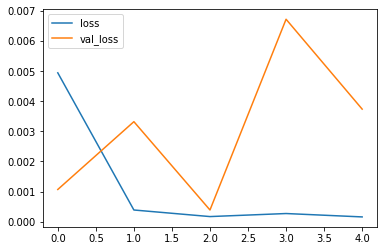

In [27]:
loss = pd.DataFrame(model.history.history)
loss.plot()

## Évaluation sur les données Test

**Tâche : Prédictions pour votre gamme de données de test (les 12 derniers mois de l'ensemble des données). N'oubliez pas d'inverser vos transformations d'échelle. Votre résultat final doit être un DataFrame avec deux colonnes, les valeurs réelles du test et les prédictions.**

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [29]:
true_predictions = scaler.inverse_transform(test_predictions)

In [30]:
# Ignorez le warning
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
test

,Consommation,Predictions
DATE,,
2020-06-01,257.217,252.610517
2020-07-01,258.543,251.898016
2020-08-01,259.580,251.194491
2020-09-01,260.190,250.462707
2020-10-01,260.352,249.711414
2020-11-01,260.721,248.941461
2020-12-01,261.564,248.161371
2021-01-01,262.200,247.375448
2021-02-01,263.346,246.580663


**Tâche : Tracez vos prédictions en fonction des valeurs réels (et vrais) du test. (Votre tracé peut être différent du nôtre).**

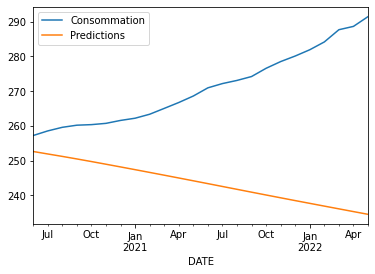

In [32]:
test.plot()

**Tâche : Calculer votre RMSE.**

In [33]:
from sklearn.metrics import mean_squared_error

In [35]:
np.sqrt(mean_squared_error(test['Consommation'],test['Predictions']))

31.562709432475142